<a href="https://colab.research.google.com/github/RoetGer/decisions-under-uncertainty/blob/main/hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install catboost
!pip install -U sklearn

     |████████████████████████████████| 302 kB 28.4 MB/s 
     |████████████████████████████████| 80 kB 7.5 MB/s 
     |████████████████████████████████| 164 kB 58.1 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 141 kB 35.3 MB/s 
     |████████████████████████████████| 111 kB 52.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=fa2af4cac46135b0f561b0fc1b018728ce2554ccae7f431d365c324906dfea97
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 67.4 MB 30 kB/s 


In [2]:
import optuna
import sklearn.metrics as skm

from catboost import CatBoostRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
from functools import partial

import numpy as np

def mean_absolute_prc_error(ytrue, ypred):
  return np.mean(np.abs(ytrue - ypred)/ytrue)

def median_absolute_prc_error(ytrue, ypred):
  return np.median(np.abs(ytrue - ypred)/ytrue)

def eval_mdl(mdl):
  error_funcs = [
    skm.mean_absolute_error,
    mean_absolute_prc_error,
    skm.median_absolute_error,
    median_absolute_prc_error,
    skm.mean_squared_error          
  ]

  print('Validation')
  [
    print(func.__name__, func(yvalid, mdl.predict(Xvalid)))
      for func in error_funcs
  ]
  
  print('\nTest')
  [
    print(func.__name__, func(ytest, mdl.predict(Xtest)))
      for func in error_funcs
  ]

In [4]:
X, y = load_boston(return_X_y=True)

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
  X, y, 
  test_size=.25, 
  random_state=5)

Xvalid, Xtest, yvalid, ytest = train_test_split(
  Xtest, ytest,
  test_size=.5,
  random_state=5)

In [6]:
params = dict(
  loss_function='MAE'
  , iterations=500
  , learning_rate=None
  , l2_leaf_reg=3.
  , bootstrap_type='No'
  , random_strength=None
  , use_best_model=True
  , max_depth=6
  , grow_policy='SymmetricTree'
  , one_hot_max_size=2
  , rsm=None #1 Random subspace method
  , nan_mode='Min'
  , leaf_estimation_method='Exact'
  , early_stopping_rounds=20
  , random_seed=5
)

mdl = CatBoostRegressor(**params)

mdl.fit(
  Xtrain, 
  ytrain, 
  eval_set=(Xvalid, yvalid))

0:	learn: 6.4141837	test: 5.6837766	best: 5.6837766 (0)	total: 48.9ms	remaining: 24.4s
1:	learn: 6.2663281	test: 5.5538885	best: 5.5538885 (1)	total: 51.6ms	remaining: 12.9s
2:	learn: 6.1443543	test: 5.4451517	best: 5.4451517 (2)	total: 54.2ms	remaining: 8.97s
3:	learn: 6.0216052	test: 5.3407240	best: 5.3407240 (3)	total: 56.5ms	remaining: 7s
4:	learn: 5.8978459	test: 5.2342340	best: 5.2342340 (4)	total: 58.8ms	remaining: 5.82s
5:	learn: 5.7805496	test: 5.1342124	best: 5.1342124 (5)	total: 61.2ms	remaining: 5.04s
6:	learn: 5.6719392	test: 5.0331422	best: 5.0331422 (6)	total: 63.4ms	remaining: 4.46s
7:	learn: 5.5540421	test: 4.9312116	best: 4.9312116 (7)	total: 65.7ms	remaining: 4.04s
8:	learn: 5.4405730	test: 4.8470331	best: 4.8470331 (8)	total: 67.9ms	remaining: 3.71s
9:	learn: 5.3546517	test: 4.7916323	best: 4.7916323 (9)	total: 70.6ms	remaining: 3.46s
10:	learn: 5.2465085	test: 4.6954344	best: 4.6954344 (10)	total: 73ms	remaining: 3.25s
11:	learn: 5.1492941	test: 4.6100199	best: 4.6

In [8]:
eval_mdl(mdl)

Validation
mean_absolute_error 1.939828952620464
mean_absolute_prc_error 0.10141613633890169
median_absolute_error 1.409625108276547
median_absolute_prc_error 0.06844816711750623
mean_squared_error 8.383751736628101

Test
mean_absolute_error 1.9001536588384225
mean_absolute_prc_error 0.09079983178421996
median_absolute_error 1.2270915426960176
median_absolute_prc_error 0.05898540411016738
mean_squared_error 9.587766915596655


In [10]:
%%time
### Optune hyperparameter optimization

def objective(trial):
  params = dict(
    loss_function='MAE'
    , iterations=1000
    , learning_rate=trial.suggest_float('learning_rate', 0.01, 0.04)
    , l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 2., 5.)
    , bootstrap_type=trial.suggest_categorical(
        'bootstrap_type', ['No', 'Bayesian', 'Bernoulli'])
    , random_strength=None
    , use_best_model=True
    , max_depth=trial.suggest_int('max_depth', 3, 12)
    , grow_policy='SymmetricTree'
    , one_hot_max_size=2
    , rsm=trial.suggest_float('rsm', 0.25, 1) #1 Random subspace method
    , nan_mode='Min'
    , leaf_estimation_method='Exact'
    , early_stopping_rounds=20
    , random_seed=5
    , logging_level='Silent'
  )

  mdl = CatBoostRegressor(**params)

  mdl.fit(
    Xtrain, 
    ytrain, 
    eval_set=(Xvalid, yvalid))
  
  return skm.mean_absolute_error(yvalid, mdl.predict(Xvalid))

study = optuna.create_study(
    direction='minimize', 
    sampler=optuna.samplers.TPESampler(seed=5))

study.optimize(
    objective, 
    n_trials=500, 
    timeout=600)

[I 2021-08-21 21:23:42,722] A new study created in memory with name: no-name-99a622e3-10c6-4648-9775-02b4b6848158
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-08-21 21:23:45,420] Trial 0 finished with value: 2.2183722125222114 and parameters: {'learning_rate': 0.016659795132692185, 'l2_leaf_reg': 4.612196918532129, 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'rsm': 0.8244308923602367}. Best is trial 0 with value: 2.2183722125222114.
[I 2021-08-21 21:23:46,100] Trial 1 finished with value: 1.9242828719753 and parameters: {'learning_rate': 0.025552539636188296, 'l2_leaf_reg': 2.8904015047286657, 'bootstrap_type': 'Bernoulli', 'max_depth': 7, 'rsm': 0.36873240078448843}. Best is trial 1 with value: 1.9242828719753.
[I 2021-08-21 21:23:46,975] Trial 2 finished with value: 2.25274778747109 and parameters: {'learning_rate': 0.03639811093603836, 'l2_leaf_reg': 2.822259385976674, 'bootstrap_type': 'Bernoulli', 'max_depth': 8, 'rsm':

CPU times: user 13min 58s, sys: 46.9 s, total: 14min 45s
Wall time: 8min 7s


In [ ]:
trial = study.best_trial

print('Best value obtained: {0:.3f}'.format(trial.value))

Best value obtained: 1.899


In [ ]:
trial.params

{'bootstrap_type': 'No',
 'l2_leaf_reg': 3.8231050593003317,
 'learning_rate': 0.030942759619221875,
 'max_depth': 7,
 'rsm': 0.6551155514532769}

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bootstrap_type,params_l2_leaf_reg,params_learning_rate,params_max_depth,params_rsm,state
0,0,2.218372,2021-08-18 22:11:27.988511,2021-08-18 22:11:30.813566,0 days 00:00:02.825055,Bayesian,4.612197,0.016660,9,0.824431,COMPLETE
1,1,1.924283,2021-08-18 22:11:30.815833,2021-08-18 22:11:31.510183,0 days 00:00:00.694350,Bernoulli,2.890402,0.025553,7,0.368732,COMPLETE
2,2,2.252748,2021-08-18 22:11:31.516383,2021-08-18 22:11:32.408907,0 days 00:00:00.892524,Bernoulli,2.822259,0.036398,8,0.699947,COMPLETE
3,3,2.205338,2021-08-18 22:11:32.411299,2021-08-18 22:11:32.767921,0 days 00:00:00.356622,Bayesian,2.854058,0.017975,4,0.972948,COMPLETE
4,4,2.230970,2021-08-18 22:11:32.770610,2021-08-18 22:11:33.690131,0 days 00:00:00.919521,Bernoulli,2.565244,0.038807,10,0.267200,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...
95,95,2.022013,2021-08-18 22:13:27.148521,2021-08-18 22:13:28.129510,0 days 00:00:00.980989,No,3.365209,0.019232,7,0.493060,COMPLETE
96,96,1.984985,2021-08-18 22:13:28.134953,2021-08-18 22:13:29.437227,0 days 00:00:01.302274,No,3.281777,0.030566,8,0.469642,COMPLETE
97,97,1.974262,2021-08-18 22:13:29.439259,2021-08-18 22:13:30.615329,0 days 00:00:01.176070,No,2.277515,0.016179,7,0.553361,COMPLETE
98,98,2.012650,2021-08-18 22:13:30.617929,2021-08-18 22:13:32.090559,0 days 00:00:01.472630,No,3.182896,0.028841,8,0.613115,COMPLETE


In [28]:
import numpy as np
import pandas as pd

np.random.seed(5)
nobs = 300

X = np.random.uniform(0.5, 2, size=nobs).reshape(-1, 1)
y = np.random.lognormal(mean=X, sigma=0.5*X)

data = pd.DataFrame({'X': X.flatten(), 'y': y.flatten()})
data

,X,y
0,0.832990,2.283621
1,1.806098,5.423909
2,0.810079,1.080908
3,1.877916,16.630056
4,1.232617,1.368372
...,...,...
295,1.745657,13.007080
296,0.699359,1.637060
297,1.047930,2.805279
298,1.869826,12.887538


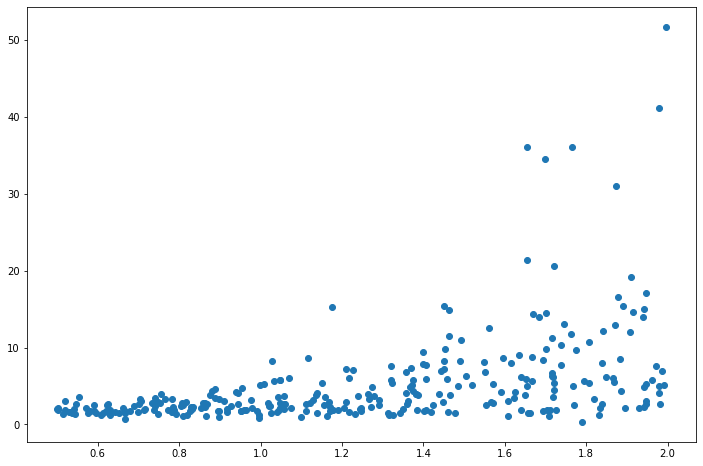

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.scatter(x=X, y=y)
plt.plot()

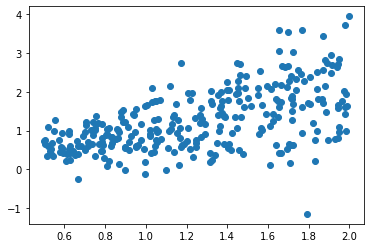

In [30]:
log_y = np.log(y)
plt.scatter(X, log_y)

In [38]:
import statsmodels.api as sm

ols = sm.OLS(endog=log_y, exog=sm.add_constant(X))
ols_res = ols.fit()
ols_res.cov_params()

array([[ 0.01320502, -0.00943112],
       [-0.00943112,  0.00755552]])

In [51]:
np.random.seed(5)
samples = np.random.lognormal(1, 1, size=100000)
log_samples = np.log(samples)

mu = log_samples.mean()
print('Mean-differences:', samples.mean(), np.exp(mu))

sigm2 = log_samples.var(ddof=1)
print('Mean-differences with correction:', samples.mean(), np.exp(mu + sigm2/2))

Mean-differences: 4.504707831982192 2.728555062973317
Mean-differences with correction: 4.504707831982192 4.508684039864379


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.base import BaseEstimator, RegressorMixin

class LogTransCorrectedModel(BaseEstimator, RegressorMixin):

  def __init__(self, mu_mdl, sigm2_mdl):
    self.mu_mdl = mu_mdl
    self.sigm2_mdl = sigm2_mdl

  def fit(self, X, y):
    log_y = np.log(y)
    self.mu_mdl.fit(X, log_y)
    resids2 = np.square(log_y - self.mu_mdl.predict(X))
    self.sigm2_mdl.fit(X, resids2)

    return self
  
  def predict(self, X):
    log_ypred = self.mu_mdl.predict(X)
    resids2_pred = self.sigm2_mdl.predict(X)

    return np.exp(log_ypred + resids2_pred/2)

In [60]:
ltcm = LogTransCorrectedModel(DummyRegressor(), DummyRegressor())

ltcm.fit(X, y)
ltcm.predict(X).mean()

4.798758703121508

In [44]:
from sklearn.base import TransformerMixin, BaseEstimator

def mm_gaussian(m, cm2):
  mu = m
  sigma = cm2
  return mu, sigma

class Gaussian_MM_Wrapper(TransformerMixin, BaseEstimator):

  def __init__(self, mean_model, variance_model):
    self.mean_model = mean_model
    self.variance_model = variance_model

  def fit(self, X, y):
    self.mean_model.fit(X, y)
    
    y_var = np.square(y - self.mean_model.predict(X))
    self.variance_model.fit(X, y_var)

    return self
  
  def predict(self, X, nsamples=0):
    mean = self.mean_model.predict(X)
    variance = self.variance_model.predict(X)

    if nsamples:
      samples = np.random.normal(
          loc=mean, 
          scale=np.sqrt(variance), 
          size=(nsamples, X.shape[0]))
      return samples
    else:
      return mean, variance

class Lognormal_MM_Wrapper(Gaussian_MM_Wrapper):

  def predict(self, X, nsamples=0):
    mean = self.mean_model_predict(X)
    variance = self.variance_model.predict(X)

    mu, sigma_sq = self.log_normal_mm_estim(mean, variance)

    if nsamples:
      samples = np.random.lognormal(
          loc=mu,
          sigma=np.sqrt(sigma_sq),
          size=(nsamples, X.shape[0]))
      return samples
    else:
      return mu, sigma_sq

  def log_normal_mm_estim(self, expect_pred, var_pred):
    sq_exp_pred = expect_pred*expect_pred
    mu = np.log(sq_exp_pred / np.sqrt(var_pred + sq_exp_pred))
    sigma_sq = np.log(1 + var_pred/sq_exp_pred)

    return mu, sigma_sq

gmm_mdl = Gaussian_MM_Wrapper(LinearRegression(), LinearRegression())

gmm_mdl.fit(X, y)

NameError: ignored